# Evaluating images (fitness) with an aesthetics predictor

Trained and inspired by Christoph Schuhmann (https://github.com/christophschuhmann/improved-aesthetic-predictor/)
TODO uses the "./testimages" folder

In [4]:
!pip install torch ftfy git+https://github.com/openai/CLIP.git gradio pytorch_lightning --quiet

In [24]:
from model_helpers.auto_device import load_torch_model, auto_clip_device
from model_helpers.images import load_images
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import pytorch_lightning as pl
import torch.nn as nn
import clip

In [22]:
class MLP(pl.LightningModule):
    def __init__(self, input_size, xcol='emb', ycol='avg_rating'):
        super().__init__()
        self.input_size = input_size
        self.xcol = xcol
        self.ycol = ycol
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.layers(x)
    
    # Do not need for inference
    # def training_step(self, batch, batch_idx):
    #         x = batch[self.xcol]
    #         y = batch[self.ycol].reshape(-1, 1)
    #         x_hat = self.layers(x)
    #         loss = F.mse_loss(x_hat, y)
    #         return loss
    # 
    # def validation_step(self, batch, batch_idx):
    #     x = batch[self.xcol]
    #     y = batch[self.ycol].reshape(-1, 1)
    #     x_hat = self.layers(x)
    #     loss = F.mse_loss(x_hat, y)
    #     return loss
    # 
    # def configure_optimizers(self):
    #     optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    #     return optimizer

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

device = auto_clip_device()
predictor_model_path = "./models/sac+logos+ava1-l14-linearMSE.pth"
url = "https://github.com/christophschuhmann/improved-aesthetic-predictor/raw/main/sac+logos+ava1-l14-linearMSE.pth"
predictor_model = load_torch_model(predictor_model_path, url, device=device)

model = MLP(768)  # CLIP embedding dim is 768 for CLIP ViT L 14
model.load_state_dict(predictor_model)
model.to(device)
model.eval() # Finalize model

clip_model, preprocess = clip.load("ViT-L/14", device=device) 

def get_aesthetic_score(pil_image):
    image = preprocess(pil_image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        im_emb_arr = normalized(image_features.cpu().detach())
        prediction = model(im_emb_arr.to(device))
    return prediction

Model loaded successfully.


## Simple inference

Aesthetic score predicted by the model:
tensor([[5.9063]])


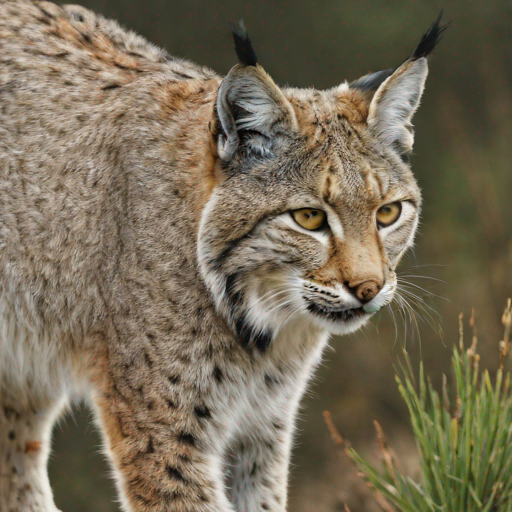

In [23]:
pil_image = Image.open("./testimages/5.png")
print("Aesthetic score predicted by the model:")
print(get_aesthetic_score(pil_image))
pil_image

## Comparison between Images

Total Scoring Time: 2.09 seconds
Average Scoring Time (per image): 0.26 seconds


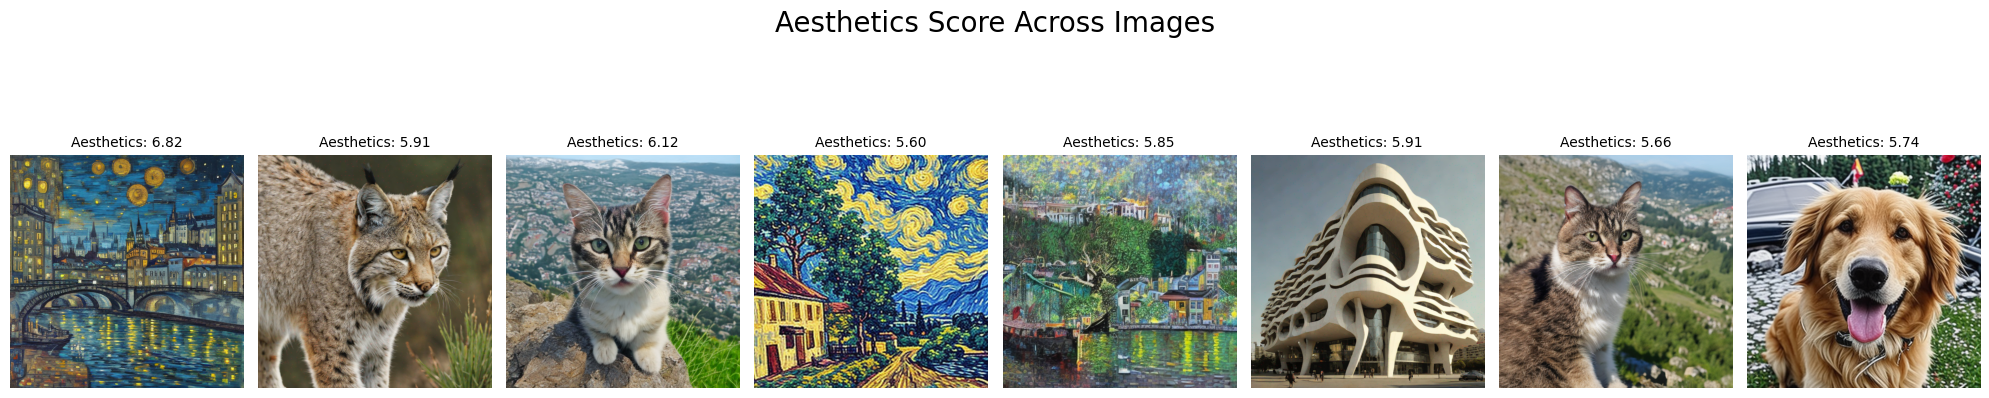

In [25]:
images = load_images("./testimages")

num_images = len(images)
fig, axs = plt.subplots(1, num_images, figsize=(20, 5)) 
fig.suptitle("Aesthetics Score Across Images", fontsize=20)

scoring_time = 0

for img_idx, image in enumerate(images):
    start_time = time.time()
    result = get_aesthetic_score(image)
    scoring_time += time.time() - start_time

    aesthetic_score = get_aesthetic_score(image).item()

    # Plotting the image
    ax = axs[img_idx]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Aesthetics: {aesthetic_score:.2f}", fontsize=10)

# Print total and average scoring time
print(f"Total Scoring Time: {scoring_time:.2f} seconds")
print(f"Average Scoring Time (per image): {scoring_time/num_images:.2f} seconds")

plt.tight_layout()
plt.show()